Notebook purpose

- Perform entire analysis

In [90]:
import contextlib
import os
import re
import sys

import linearmodels as lm
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tabulate

sys.path.append("/Users/fgu/dev/projects/entropy")
import entropy.analysis.make_analysis_data as ad
import entropy.data.cleaners as cl
import entropy.data.creators as cr
import entropy.data.selectors as sl
import entropy.figures.figures as ff
import entropy.figures.helpers as fh
import entropy.helpers.aws as ha
import entropy.helpers.data as hd
import entropy.helpers.helpers as hh
from entropy import config

sns.set_style("whitegrid")
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.set_option("max_colwidth", None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

fs = s3fs.S3FileSystem(profile="3di")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
df = hd.read_analysis_data()
hd.inspect(df)

Time for read_analysis_data            : 1.82 seconds
(107,296, 24)


txn_count_sa  txn_count_ca  sa_inflows  sa_outflows  \
user_id date                                                              
37      2012-02-29           3.0           8.0      3340.0       1740.0   
        2012-03-31           2.0           9.0         0.0          0.0   

                    sa_net_inflows  sa_scaled_inflows  sa_scaled_outflows  \
user_id date                                                                
37      2012-02-29          1600.0           2.135478            1.112494   
        2012-03-31             0.0           0.000000            0.000000   

                    sa_scaled_net_inflows  log_monthly_spend  \
user_id date                                                   
37      2012-02-29               1.022983           6.269551   
        2012-03-31               0.000000           6.063506   

                    tag_spend_services  tag_spend_household  \
user_id date                                                  
37      2012-02-29            0.224898             0.591852   
        2012-03-31            0.028799             0.761841   

                    tag_spend_communication  tag_spend_other_spend  \
user_id date                                                         
37      2012-02-29                 0.094654               0.088596   
        2012-03-31                 0.116312               0.093049   

                    tag_spend_retail  tag_spend_finance  tag_spend_motor  \
user_id date                                                               
37      2012-02-29               0.0                0.0              0.0   
        2012-03-31               0.0                0.0              0.0   

                    tag_spend_travel  tag_spend_hobbies        income  \
user_id date                                                            
37      2012-02-29               0.0                0.0  18768.632812   
        2012-03-31               0.0                0.0  18768.632812   

                    log_income  female   age    region  entropy_sptac  
user_id date                                                           
37      2012-02-29    9.839942     0.0  27.0  Scotland       2.899397  
        2012-03-31    9.839942     0.0  27.0  Scotland       3.039149

## Sample description

Sample selection - see paper

Unique users

In [3]:
df.index.get_level_values("user_id").nunique()

3495

User characteristics

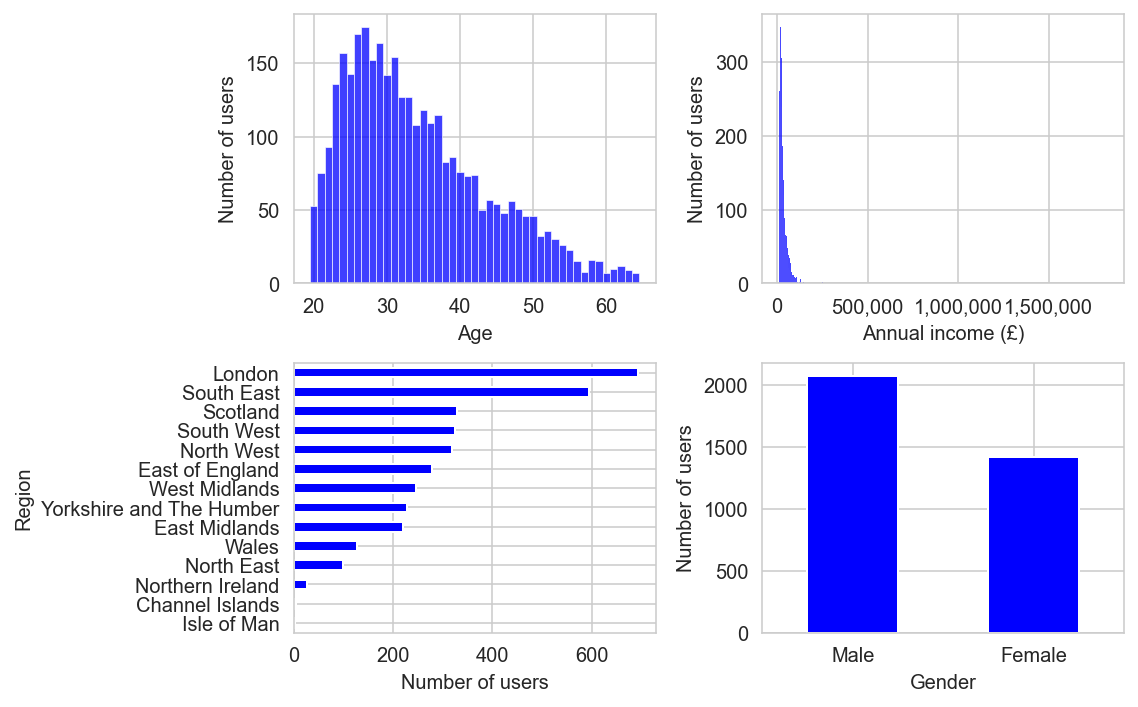

In [4]:
ff.sample_description(df, write=False)

Dev

In [ ]:
def txns_counts(df, write=True):
    """Plots distribution of txns per user-month for current and savings accounts."""
    colour = "blue"
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    for idx, var in enumerate(["txn_count_ca", "txn_count_sa"]):
        sns.histplot(data=df[var], color=colour, stat="percent", ax=ax[idx])
        fh.set_axis_labels(ax[idx], var, "User-months (%)")
    return fig


fig = txns_counts(df)

In [ ]:
def num_txns_by_account_type(df, write=True):
    """Plots boxenplot with number of monthly transactions by account type."""

    def make_data(df):
        mask = df.account_type.isin(["current", "credit card", "savings"])
        return (
            df.loc[mask]
            .set_index("date")
            .groupby(["account_type", "account_id"], observed=True)
            .resample("M")
            .id.count()
            .rename("num_txns")
            .reset_index()
        )

    def make_figure(df):
        fig, ax = plt.subplots()
        order = ["current", "credit card", "savings"]
        ax = sns.boxenplot(data=df, x="num_txns", y="account_type", order=order)
        return fig, ax

    def set_ytick_labels(ax):
        # capitalise first letter of, and add 'account' suffix to, ytick labels
        to_label = lambda x: " ".join([x[0].upper() + x[1:], "accounts"])
        ytick_labels = [to_label(i.get_text()) for i in ax.get_yticklabels()]
        ax.set_yticklabels(ytick_labels)

    fig, ax = make_figure(make_data(df))
    set_ytick_labels(ax)
    fh.set_axis_labels(ax, xlabel="Number of transactions per month", ylabel="")
    fh.set_size(fig)
    if write:
        fh.save_fig(fig, "num_txns_by_account_type.png")

In [78]:
try:
    ff.num_txns_by_account_type(df, write=False)
except AttributeError:
    pass

## Summary statistics

In [92]:
import entropy.analysis.sumstats_table as eas

eas.main(df, write=False)

,count,mean,std,min,max,25%,50%,75%
txn_count_sa,107296.0,4.239534,8.976829,0.000000,3.890000e+02,0.000000,2.000000,5.000000
txn_count_ca,107296.0,88.221266,54.190857,0.000000,9.060000e+02,52.000000,78.000000,113.000000
sa_inflows,107296.0,1291.948853,23460.371094,0.000000,6.215068e+06,0.000000,1.500000,424.480011
sa_outflows,107296.0,1197.387451,17849.087891,0.000000,4.524177e+06,0.000000,0.000000,400.000000
sa_net_inflows,107296.0,94.561409,12172.730469,-705792.062500,1.690891e+06,0.000000,0.000000,78.632504
sa_scaled_inflows,107296.0,0.409382,4.410349,0.000000,6.456697e+02,0.000000,0.000664,0.178858
sa_scaled_outflows,107296.0,0.388441,3.234974,0.000000,3.875515e+02,0.000000,0.000000,0.169043
sa_scaled_net_inflows,107296.0,0.020941,4.537611,-387.468764,6.215899e+02,0.000000,0.000000,0.031926
log_monthly_spend,107296.0,7.605353,0.784178,5.300814,1.395425e+01,7.077911,7.561228,8.087591
tag_spend_services,107296.0,0.196234,0.145358,0.000000,1.000000e+00,0.091668,0.161639,0.263964


## Dependent variable - savings

## Independent variable - entropy

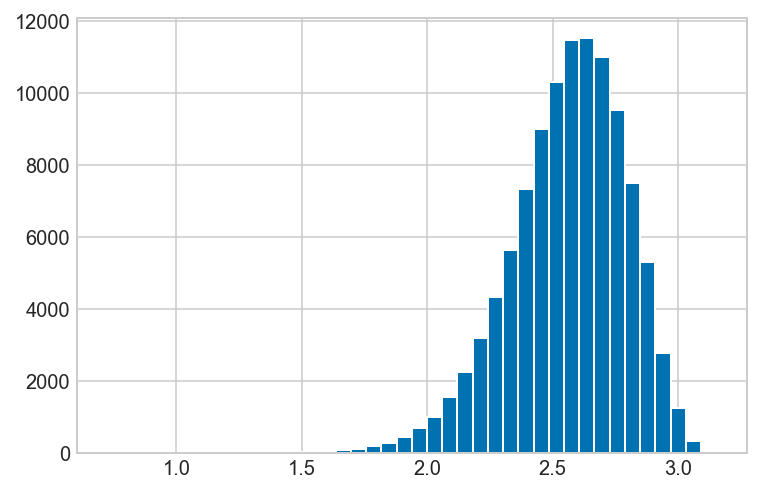

In [11]:
df.entropy_sptac.hist(bins=40);

## Correlations

In [52]:
def make_data(df, col_name, **trim_kws):
    return (
        df.set_index("entropy_sptac", append=True)
        .loc[:, col_name]
        .rename("value")
        .reset_index("entropy_sptac")
    )


def make_plot(df, axis):
    sns.regplot(
        data=df,
        y="value",
        x="entropy_sptac",
        lowess=True,
        line_kws=dict(color="orange"),
        ci=95,
        ax=ax[axis],
    )

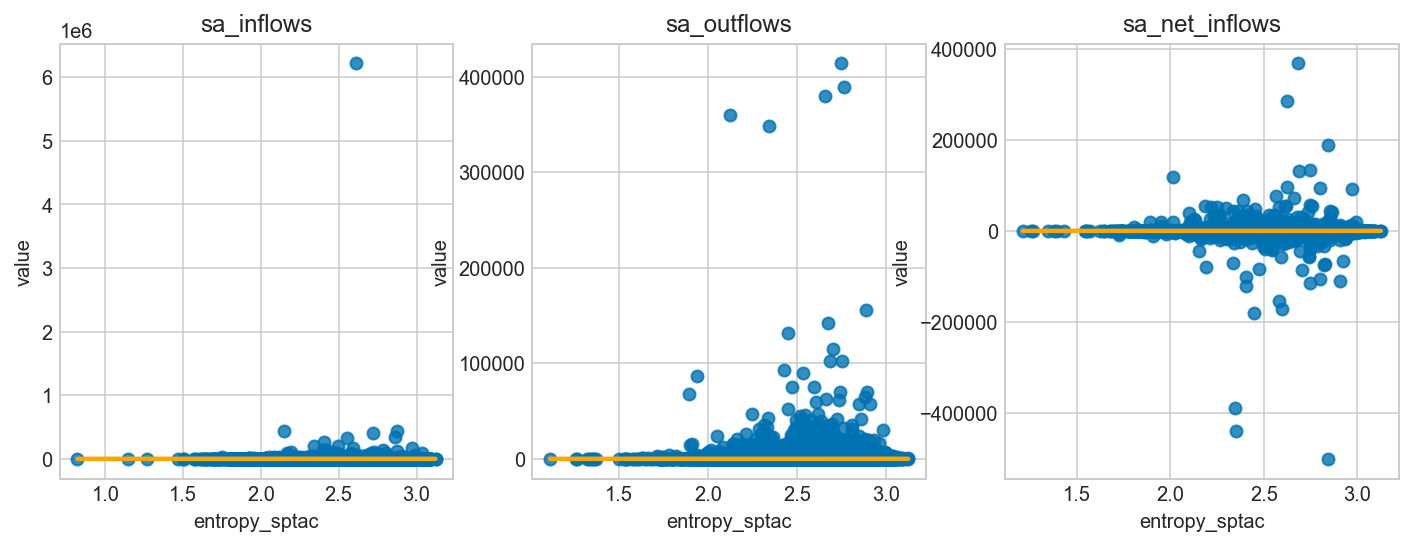

In [53]:
pattern = "sa_[oin]"
outcome_vars = df.filter(regex="sa_[oin]").columns
num_vars = len(outcome_vars)
fig, ax = plt.subplots(1, num_vars, figsize=(4 * num_vars, 4))
for idx, var in enumerate(outcome_vars):
    d = make_data(df, col_name=var).sample(frac=0.1)
    make_plot(d, idx)
    ax[idx].set_title(var)

In [ ]:
pattern = "sa_scaled"
outcome_vars = df.filter(like="sa_scaled")
num_vars = len(outcome_vars)
fig, ax = plt.subplots(1, num_vars, figsize=(4 * num_vars, 4))
for idx, var in enumerate(outcome_vars):
    d = make_data(df, col_name=var).sample(0.1)
    make_plot(d, idx)
    ax[idx].set_title(var)

## Results

In [67]:
d = hd.read_sample("777")

Time for read_sample                   : 1.56 seconds


In [86]:
ad.tag_monthly_spend_prop(d)

tag                 tag_spend_finance  tag_spend_motor  tag_spend_household  \
user_id date                                                                  
7777    2012-11-30       11011.580078       164.750000           163.029999   
        2012-12-31        1051.530029       361.089996           207.290009   
        2013-01-31         758.419983       208.069992           300.510010   
        2013-02-28        1058.839966       149.309998           165.190002   
        2013-03-31         683.179993        86.930000           247.300003   
...                               ...              ...                  ...   
553777  2019-10-31          49.910000              NaN          1010.089966   
        2019-11-30         659.780029              NaN           782.239990   
        2019-12-31          49.090000              NaN           971.549988   
        2020-01-31       11118.940430              NaN           726.279968   
        2020-02-29           8.500000              NaN           769.089966   

tag                 tag_spend_retail  tag_spend_other_spend  \
user_id date                                                  
7777    2012-11-30         48.100002             484.020020   
        2012-12-31        145.490005            1629.300049   
        2013-01-31         17.980000             154.600006   
        2013-02-28         11.490000             350.359985   
        2013-03-31         81.470001             458.950012   
...                              ...                    ...   
553777  2019-10-31       1109.920044              50.000000   
        2019-11-30        461.190002              13.000000   
        2019-12-31        448.589996              85.900002   
        2020-01-31         85.529999                    NaN   
        2020-02-29         85.000000              50.549999   

tag                 tag_spend_services  tag_spend_communication  \
user_id date                                                      
7777    2012-11-30          230.839996                22.969999   
        2012-12-31          375.070007               168.290009   
        2013-01-31          474.980011               103.059998   
        2013-02-28          304.049988                44.699997   
        2013-03-31          402.940002                 9.990000   
...                                ...                      ...   
553777  2019-10-31          145.020004                84.440002   
        2019-11-30          152.319992                44.570000   
        2019-12-31          169.580002                44.570000   
        2020-01-31          237.750000                84.440002   
        2020-02-29          188.270004                24.570000   

tag                 tag_spend_travel  tag_spend_hobbies  
user_id date                                             
7777    2012-11-30               NaN                NaN  
        2012-12-31          9.500000                NaN  
        2013-01-31         11.050000                NaN  
        2013-02-28               NaN                NaN  
        2013-03-31        231.800003                NaN  
...                              ...                ...  
553777  2019-10-31         20.700001                NaN  
        2019-11-30        247.330002                NaN  
        2019-12-31        122.430000                NaN  
        2020-01-31         46.200001                NaN  
        2020-02-29         34.820000                0.5  

[1165 rows x 9 columns]

### Fixed effects

In [97]:
data = df
y = data["sa_scaled_inflows"]
tag_spend = list(df.filter(like="tag_spend").columns)
full_controls = ["log_income", "log_monthly_spend"] + tag_spend[:-1]


b = lm.PanelOLS(
    y,
    data["entropy_sptac"],
    entity_effects=True,
    time_effects=True,
).fit()
ba = lm.PanelOLS(
    y,
    data[["entropy_sptac", "log_income"]],
    entity_effects=True,
    time_effects=True,
).fit()
bd = lm.PanelOLS(
    y,
    data[["entropy_sptac", "log_monthly_spend"]],
    entity_effects=True,
    time_effects=True,
).fit()
be = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + tag_spend[:-1]],
    entity_effects=True,
    time_effects=True,
).fit()
bf = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=True,
    time_effects=True,
).fit()
bg = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=True,
    time_effects=True,
).fit(cov_type="clustered", cluster_entity=True)
bh = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=True,
    time_effects=False,
).fit(cov_type="clustered", cluster_entity=True)
bi = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=False,
    time_effects=True,
).fit(cov_type="clustered", cluster_entity=True)
bj = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=False,
    time_effects=False,
).fit(cov_type="clustered", cluster_entity=True)


lm.panel.compare([b, ba, bd, be, bf, bg, bh, bi, bj], stars=True)

/Users/fgu/miniconda3/envs/entropy/lib/python3.9/site-packages/linearmodels/panel/results.py:1010: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  vals = concat(


,Model 0,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,Model 7,Model 8
Dep. Variable,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows
Estimator,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS
No. Observations,107296,107296,107296,107296,107296,107296,107296,107296,107296
Cov. Est.,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Clustered,Clustered,Clustered,Clustered
R-squared,9.548e-06,0.0005,0.0018,0.0002,0.0027,0.0027,0.0028,0.0061,0.0146
R-Squared (Within),9.284e-06,0.0005,0.0018,0.0003,0.0027,0.0027,0.0028,0.0024,0.0024
R-Squared (Between),-0.1107,-13.844,-3.5250,0.0934,-3.0453,-3.0453,-2.5978,0.1312,0.1382
R-Squared (Overall),-0.0108,-1.3933,-0.3635,0.0090,-0.3018,-0.3018,-0.2568,0.0141,0.0146
F-statistic,0.9901,28.384,92.464,2.8433,25.640,25.640,26.040,59.837,144.30
P-value (F-stat),0.3197,0.0000,0.0000,0.0024,0.0000,0.0000,0.0000,0.0000,0.0000


In [95]:
data = df
y = data["sa_inflows"]
tag_spend = list(df.filter(like="tag_spend").columns)
full_controls = ["log_income", "log_monthly_spend"] + tag_spend[:-1]


b = lm.PanelOLS(
    y,
    data["entropy_sptac"],
    entity_effects=True,
    time_effects=True,
).fit()
ba = lm.PanelOLS(
    y,
    data[["entropy_sptac", "log_income"]],
    entity_effects=True,
    time_effects=True,
).fit()
bd = lm.PanelOLS(
    y,
    data[["entropy_sptac", "log_monthly_spend"]],
    entity_effects=True,
    time_effects=True,
).fit()
be = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + tag_spend[:-1]],
    entity_effects=True,
    time_effects=True,
).fit()
bf = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=True,
    time_effects=True,
).fit()
bg = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=True,
    time_effects=True,
).fit(cov_type="clustered", cluster_entity=True)
bh = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=True,
    time_effects=False,
).fit(cov_type="clustered", cluster_entity=True)
bi = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=False,
    time_effects=True,
).fit(cov_type="clustered", cluster_entity=True)
bj = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=False,
    time_effects=False,
).fit(cov_type="clustered", cluster_entity=True)


lm.panel.compare([b, ba, bd, be, bf, bg, bh, bi, bj], stars=True)

/Users/fgu/miniconda3/envs/entropy/lib/python3.9/site-packages/linearmodels/panel/results.py:1010: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  vals = concat(


,Model 0,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,Model 7,Model 8
Dep. Variable,sa_inflows,sa_inflows,sa_inflows,sa_inflows,sa_inflows,sa_inflows,sa_inflows,sa_inflows,sa_inflows
Estimator,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS
No. Observations,107296,107296,107296,107296,107296,107296,107296,107296,107296
Cov. Est.,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Clustered,Clustered,Clustered,Clustered
R-squared,2.97e-06,3.711e-05,0.0009,8.9e-05,0.0009,0.0009,0.0009,0.0053,0.0075
R-Squared (Within),3.935e-06,4.764e-05,0.0009,9.283e-05,0.0009,0.0009,0.0009,0.0006,0.0002
R-Squared (Between),-0.0186,-0.1242,-0.8894,-0.0112,-1.2358,-1.2358,-1.2670,-7.5494,0.0558
R-Squared (Overall),-0.0035,-0.0277,-0.1835,-0.0021,-0.2537,-0.2537,-0.2600,-1.5241,0.0075
F-statistic,0.3080,1.9241,44.459,1.0255,8.5301,8.5301,8.9177,51.709,73.813
P-value (F-stat),0.5789,0.1460,0.0000,0.4164,0.0000,0.0000,0.0000,0.0000,0.0000


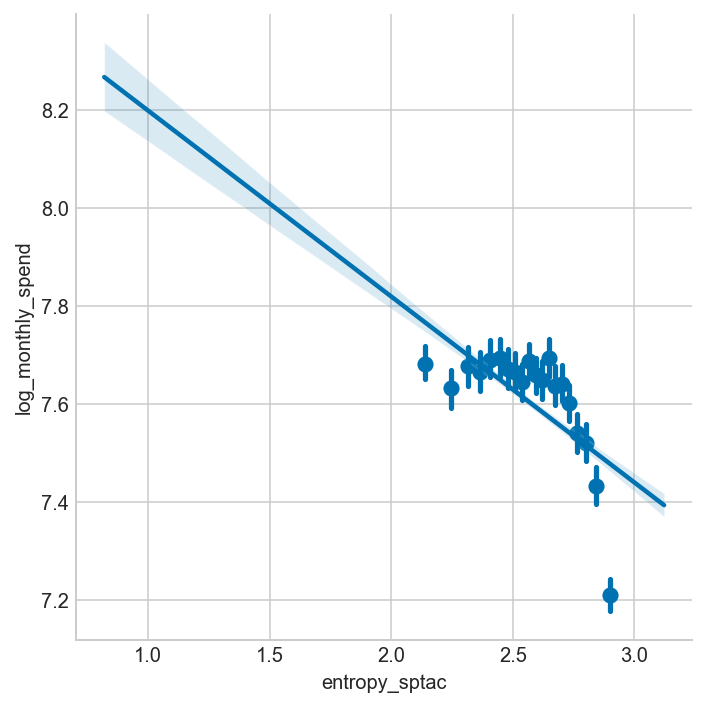

In [96]:
sns.lmplot(
    data=df.sample(frac=0.3), x="entropy_sptac", y="log_monthly_spend", x_bins=20
)

### Pooled regressions

In [98]:
full_controls = ["log_income", "age", "female", "log_monthly_spend"] + tag_spend

a = lm.PanelOLS(y, sm.add_constant(data["entropy_sptac"])).fit()
aa = lm.PanelOLS(y, sm.add_constant(data[["entropy_sptac", "log_income"]])).fit()
ab = lm.PanelOLS(y, sm.add_constant(data[["entropy_sptac", "age"]])).fit()
ac = lm.PanelOLS(y, sm.add_constant(data[["entropy_sptac", "female"]])).fit()
ad = lm.PanelOLS(y, sm.add_constant(data[["entropy_sptac", "log_monthly_spend"]])).fit()
ae = lm.PanelOLS(y, sm.add_constant(data[["entropy_sptac"] + tag_spend[:-1]])).fit()
af = lm.PanelOLS(y, sm.add_constant(data[["entropy_sptac"] + full_controls])).fit()
ag = lm.PanelOLS(y, sm.add_constant(data[["entropy_sptac"] + full_controls])).fit(
    cov_type="clustered", cluster_entity=True
)


lm.panel.compare([a, aa, ab, ac, ad, ae, af, ag], stars=True)

,Model 0,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,Model 7
Dep. Variable,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows
Estimator,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS
No. Observations,107296,107296,107296,107296,107296,107296,107296,107296
Cov. Est.,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Clustered
R-squared,2.985e-05,9.394e-05,0.0014,0.0002,0.0037,0.0011,0.0069,0.0069
R-Squared (Within),-4.12e-05,9.208e-05,-3.02e-05,-5.145e-05,0.0018,1.925e-05,0.0025,0.0025
R-Squared (Between),0.0006,0.0005,0.0193,0.0025,0.0252,0.0124,0.0618,0.0618
R-Squared (Overall),2.985e-05,9.394e-05,0.0014,0.0002,0.0037,0.0011,0.0069,0.0069
F-statistic,3.2024,5.0403,77.068,8.4124,197.00,12.888,52.893,52.893
P-value (F-stat),0.0735,0.0065,0.0000,0.0002,0.0000,0.0000,0.0000,0.0000
